In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import time
from torch.autograd import Variable
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data_path='/kaggle/input/face-recognition/content/drive/MyDrive/Datasets'

In [3]:
os.listdir(data_path)

['list_attribute.txt',
 'gender_classification.csv',
 'Images',
 'class_identity.txt']

In [4]:
# Load data from a CSV file
data = pd.read_csv(os.path.join(data_path, 'gender_classification.csv'))

# Split the data into train and test sets with a 80:20 ratio
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [5]:
data.columns = ["image_path", "Male"]

data

,image_path,Male
0,000041.jpg,1
1,000044.jpg,0
2,000047.jpg,0
3,000050.jpg,1
4,000063.jpg,0
...,...,...
9995,202548.jpg,0
9996,202554.jpg,1
9997,202557.jpg,0
9998,202566.jpg,1


In [6]:
class GenderDataset(Dataset):
    def __init__(self, data, image_folder_path, transform=None):
        self.data = data
        self.image_folder_path = image_folder_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_folder_path, self.data.iloc[idx, 0])
        image = Image.open(image_path).convert('RGB')
        gender = self.data.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(gender, dtype=torch.long)

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
train_set = GenderDataset(train_data, image_folder_path=os.path.join(data_path, "Images"), transform=transform)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)

test_set = GenderDataset(test_data, os.path.join(data_path, "Images"), transform=transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)

In [9]:
# please Define the model optimizer and criterion (loss function)
model = models.vgg19()
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 2)
model = nn.DataParallel(model)

use_gpu = torch.cuda.is_available()

if use_gpu:
  model = model.to("cuda")

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [10]:
model

DataParallel(
  (module): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

In [11]:
import time
from torch.autograd import Variable

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, use_gpu=torch.cuda.is_available(), num_epochs=10):
    #please define the training model here
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    history = {'train': {'acc': [], 'loss': []}, 'test': {'acc': [], 'loss': []}}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            history[phase]['acc'].append(epoch_acc.detach().cpu())
            history[phase]['loss'].append(epoch_loss.detach().cpu())

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
                torch.save(state,'best.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


In [12]:
dataloaders = {
    "train":train_loader, "test":test_loader
}
dataset_sizes= {
    "train":len(train_set), "test":len(test_set)
}

In [13]:
model, history = train_model(model, dataloaders, dataset_sizes, criterion, optimizer, use_gpu, 10)

Epoch 0/9
----------
train Loss: 0.0200 Acc: 0.6323
test Loss: 0.0178 Acc: 0.7050

Epoch 1/9
----------
train Loss: 0.0167 Acc: 0.7374
test Loss: 0.0155 Acc: 0.7660

Epoch 2/9
----------
train Loss: 0.0148 Acc: 0.7788
test Loss: 0.0132 Acc: 0.8140

Epoch 3/9
----------
train Loss: 0.0120 Acc: 0.8349
test Loss: 0.0106 Acc: 0.8480

Epoch 4/9
----------
train Loss: 0.0094 Acc: 0.8729
test Loss: 0.0094 Acc: 0.8865

Epoch 5/9
----------
train Loss: 0.0077 Acc: 0.9009
test Loss: 0.0073 Acc: 0.9085

Epoch 6/9
----------
train Loss: 0.0063 Acc: 0.9208
test Loss: 0.0069 Acc: 0.9120

Epoch 7/9
----------
train Loss: 0.0052 Acc: 0.9306
test Loss: 0.0057 Acc: 0.9310

Epoch 8/9
----------
train Loss: 0.0044 Acc: 0.9459
test Loss: 0.0054 Acc: 0.9375

Epoch 9/9
----------
train Loss: 0.0038 Acc: 0.9535
test Loss: 0.0052 Acc: 0.9395

Training complete in 36m 24s
Best test Acc: 0.939500


In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
def evaluate_model(model, test_loader, class_names):
    was_training = model.training
    model.eval()

    CM = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            CM += confusion_matrix(labels.cpu(), preds.cpu(), labels = [0,1])

            model.train(mode=was_training)

        model.train(mode=was_training)

        tn = CM[0][0]
        tp = CM[1][1]
        fp = CM[0][1]
        fn = CM[1][0]

        acc = (tp + tn) / (tp + tn + fp + fn)
        recall=tp/(tp+fn)
        precision=tp/(tp+fp)
        f1_score = ((2*recall*precision)/(recall+precision))

        print(f"Accuracy : {acc:.4f}")
        print(f"Recall : {recall:.4f}")
        print(f"Precision : {precision:.4f}")
        print(f"F1_Score : {f1_score:.4f}")

        # Plot the confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=CM,
                              display_labels=class_names)
        disp.plot()
        plt.savefig('confusion_matrix.png')

Accuracy : 0.9395
Recall : 0.9186
Precision : 0.9333
F1_Score : 0.9259


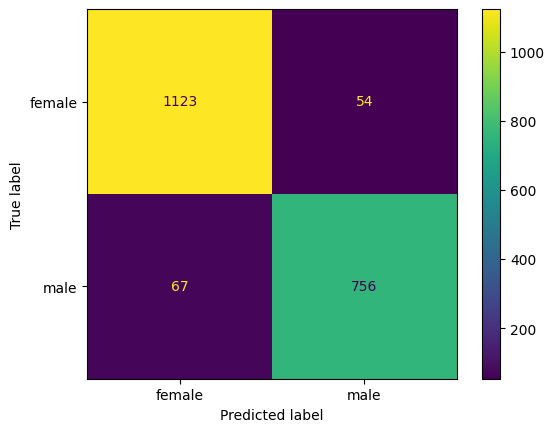

In [16]:
evaluate_model(model, dataloaders['test'], ["female", "male"])

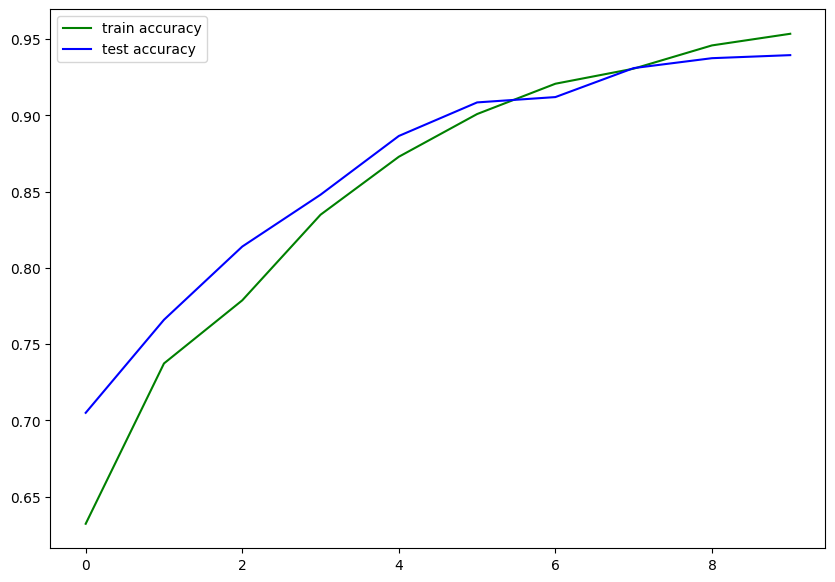

In [17]:
# Visualizing the Plots
plt.figure(figsize=(10, 7))
plt.plot(history['train']['acc'], color='green', label='train accuracy')
plt.plot(history['test']['acc'], color='blue', label='test accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

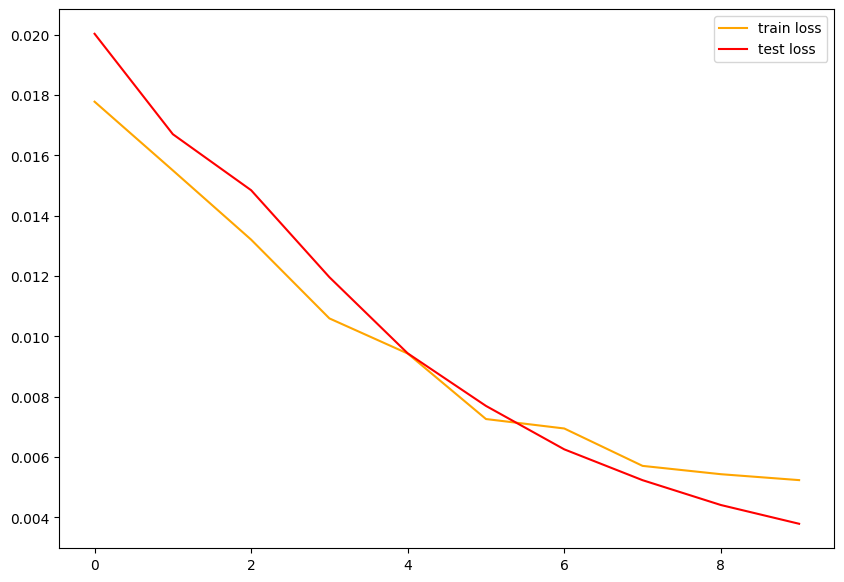

In [18]:
plt.figure(figsize=(10, 7))
plt.plot(history['test']['loss'], color='orange', label='train loss')
plt.plot(history['train']['loss'], color='red', label='test loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

In [20]:
def inverse_norm(img):
  img[0, :, :] = img[0, :, :] * .229 + .485
  img[1, :, :] = img[1, :, :] * .224 + .456
  img[2, :, :] = img[2, :, :] * .225 + .406

  return img

In [21]:
feature, target = next(iter(dataloaders['test']))
feature, target = feature.to(device), target.to(device)

with torch.no_grad():
    model.eval() 
    output = model(feature)
    pred_ = output.argmax(1)

pred_

tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')

In [22]:
label2cat = ["female", "male"]

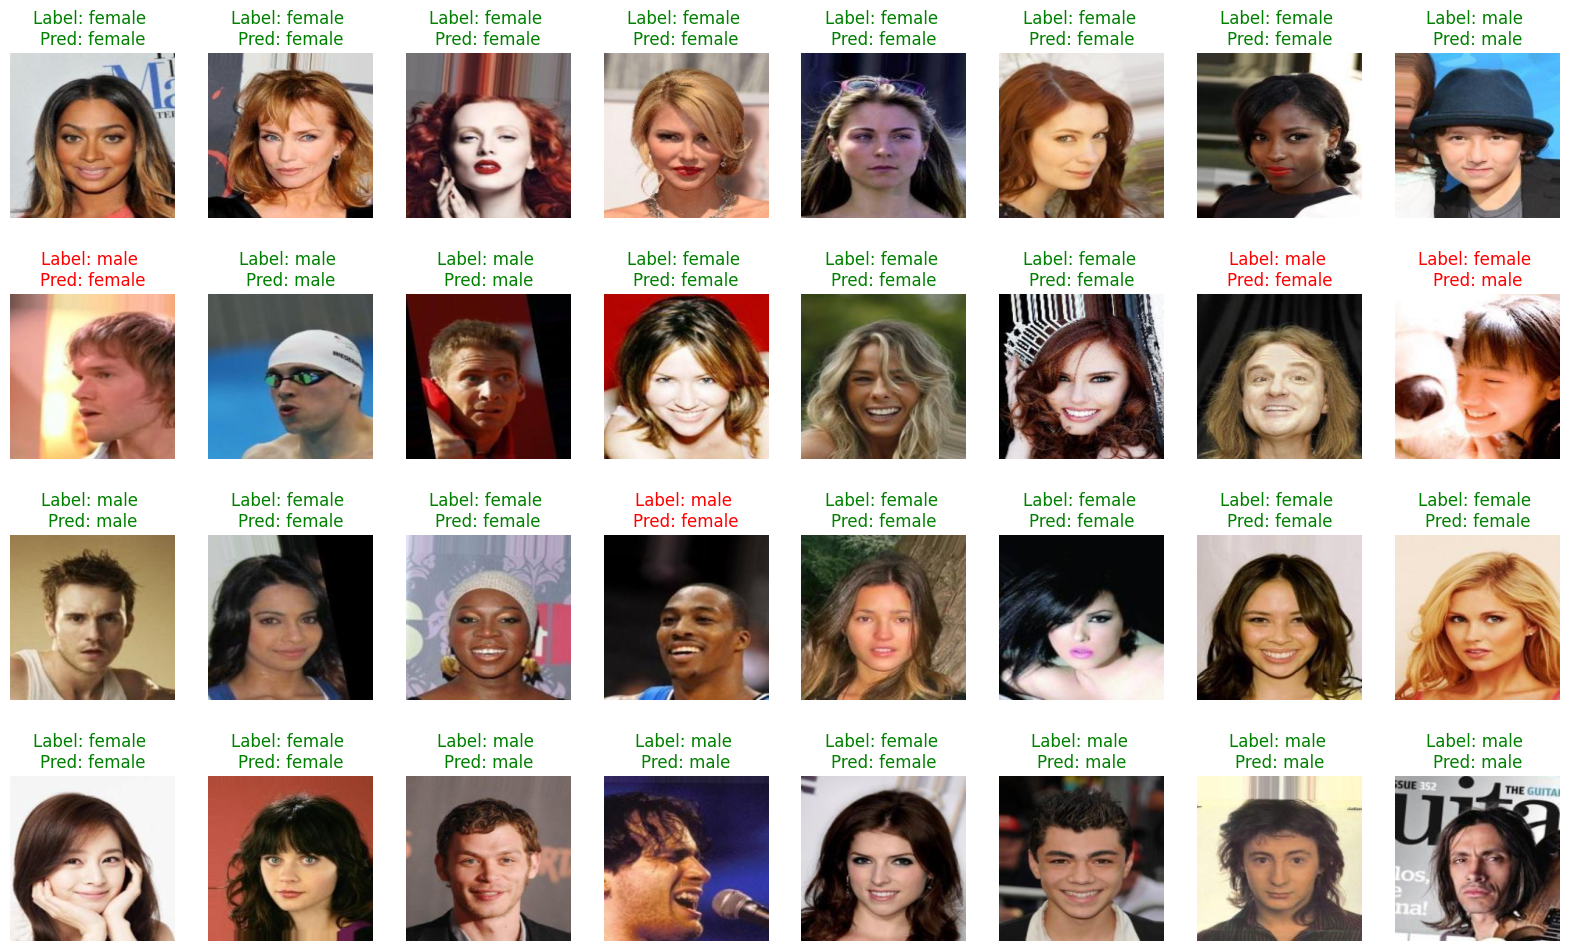

In [23]:
fig, axes = plt.subplots(4, 8, figsize = (20, 12))
for img, label, pred, ax in zip(feature, target, pred_, axes.flatten()):
    ax.imshow(inverse_norm(img).permute(1,2,0).cpu())
    font = {'color': 'r'} if label != pred else {'color' : 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Label: {label} \nPred: {pred}", fontdict = font)
    ax.axis('off')
    plt.savefig('output.png')